# Job Change of Data Scientists | Data Science Project | Data Preprocessing

> Data from [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists) with modification in the problem context.

*This project was completed as a part of Rakamin Academy Data Science Bootcamp.*

Data is the new oil, and many companies are investing in developing their employees' data science skills. However, after completing their training, many employees seek new job opportunities, leading to talent loss and wasted investment for companies. Ascencio, a leading data science consulting firm, aims to help businesses **reduce attrition rates** by **predicting which employees are likely to leave** after completing a data science course.

To achieve this, we will build **machine learning models** to predict whether an employee will seek a job change or not. For further analysis, we will also connect **AI agent** to prediction result.

# Prepare Everything!

In [179]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings('ignore')

# import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# import models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier

# import feature importance
import shap
from sklearn.inspection import permutation_importance


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)


numpy version :  1.26.4
pandas version :  2.2.3


In [180]:
# read the data
df_train = pd.read_csv(r'Data/aug_train.csv')

# Data Preprocessing

## A. Feature Selection

Check that we will only use these columns as features<br/>
'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'

In [181]:
# drop column enrollee_id, city, and training_hours
print("df_train Dataframe")
df_train.drop(['enrollee_id','city','training_hours'], axis=1, inplace=True)
display(df_train.head())

df_train Dataframe


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,0.0


## B. Feature Revision

We will rename and imputation data based on 1_EDA.ipynb analysis. We will set copy to dftr dataframe from df_train dataframe and dfte dataframe from df_test dataframe.

In [182]:
# feature revision for df_train
# rename relevent_experience to relevant_experience
df_train.rename(columns={'relevent_experience':'relevant_experience'}, inplace=True)

# copy the data
dftr = df_train.copy()

# change relevant_experience
dftr['relevant_experience'] = dftr['relevant_experience'].apply(lambda x: True if x == "Has relevent experience" 
                                                 else np.nan if pd.isna(x) else False)

# change enrolled_university
dftr['enrolled_university'] = dftr['enrolled_university'].apply(lambda x: "No Enroll" if x == "no_enrollment"
                                                                        else "Full Time" if x == "Full time course" 
                                                                        else np.nan if pd.isna(x) else "Part Time")

# imputation major_discipline
dftr['major_discipline'] = np.where((dftr['education_level'].isin(['Graduate', 'Masters'])) & (dftr['major_discipline'] == 'No Major'), np.nan, 
                        np.where((dftr['education_level'].isin(['Primary School', 'High School'])) & (dftr['major_discipline'].isnull()),'No Major',dftr['major_discipline']))

# grouping company_size
dftr['company_size'] = dftr['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)

# rename company_type
dftr['company_type'] = dftr['company_type'].apply(lambda x: "Early Startup" if x == "Early Stage Startup" else x)

# check data
dftr.head(10)

,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,True,No Enroll,Graduate,STEM,>20,NaN,NaN,1,1.0
1,0.776,Male,False,No Enroll,Graduate,STEM,15,50-99,Pvt Ltd,>4,0.0
2,0.624,NaN,False,Full Time,Graduate,STEM,5,NaN,NaN,never,0.0
3,0.789,NaN,False,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,1.0
4,0.767,Male,True,No Enroll,Masters,STEM,>20,50-99,Funded Startup,4,0.0
5,0.764,NaN,True,Part Time,Graduate,STEM,11,NaN,NaN,1,1.0
6,0.920,Male,True,No Enroll,High School,No Major,5,50-99,Funded Startup,1,0.0
7,0.762,Male,True,No Enroll,Graduate,STEM,13,<10,Pvt Ltd,>4,1.0
8,0.920,Male,True,No Enroll,Graduate,STEM,7,50-99,Pvt Ltd,1,1.0
9,0.920,NaN,True,No Enroll,Graduate,STEM,17,10000+,Pvt Ltd,>4,0.0


In [183]:
# drop rows with equal or more than 4 NaN values train data
print(f"Rows in dftr before is {dftr.shape[0]}")
dftr = dftr[dftr.isnull().sum(axis=1) < 4]
dftr.reset_index(inplace=True, drop=True)
print(f"Rows in dftr after is {dftr.shape[0]}")

Rows in dftr before is 19158
Rows in dftr after is 18628


## C. Type Data

In [184]:
# check type data of train data
print(dftr.info())
# relevant_experience have bool type since it only yes or no value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18628 non-null  float64
 1   gender                  14487 non-null  object 
 2   relevant_experience     18628 non-null  bool   
 3   enrolled_university     18396 non-null  object 
 4   education_level         18481 non-null  object 
 5   major_discipline        18258 non-null  object 
 6   experience              18593 non-null  object 
 7   company_size            13190 non-null  object 
 8   company_type            12992 non-null  object 
 9   last_new_job            18392 non-null  object 
 10  target                  18628 non-null  float64
dtypes: bool(1), float64(2), object(8)
memory usage: 1.4+ MB
None


## D. Feature Encoding

In [185]:
# define ordered categories as lists
relevant_experience_cats = [False, True]
enrolled_university_cats = ['No Enroll', 'Part Time', 'Full Time']
education_level_cats = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
experience_cats = ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
company_size_cats = ['<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
last_new_job_cats = ['never', '1', '2', '3', '4', '>4']
categories = [relevant_experience_cats, enrolled_university_cats, education_level_cats, experience_cats, company_size_cats, last_new_job_cats]

# define columns for ordinal encoding
cats_oe = ['relevant_experience', 'enrolled_university', 'education_level', 'experience', 'company_size', 'last_new_job']

# ordinal encoding
oe = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=np.nan)
oe.fit(dftr[cats_oe])
dftr[cats_oe] = oe.transform(dftr[cats_oe])
display(dftr.head(10))


,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,target
0,0.920,Male,1.0,0.0,2.0,STEM,21.0,NaN,NaN,1.0,1.0
1,0.776,Male,0.0,0.0,2.0,STEM,15.0,2.0,Pvt Ltd,5.0,0.0
2,0.624,NaN,0.0,2.0,2.0,STEM,5.0,NaN,NaN,0.0,0.0
3,0.789,NaN,0.0,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,1.0
4,0.767,Male,1.0,0.0,3.0,STEM,21.0,2.0,Funded Startup,4.0,0.0
5,0.764,NaN,1.0,1.0,2.0,STEM,11.0,NaN,NaN,1.0,1.0
6,0.920,Male,1.0,0.0,1.0,No Major,5.0,2.0,Funded Startup,1.0,0.0
7,0.762,Male,1.0,0.0,2.0,STEM,13.0,0.0,Pvt Ltd,5.0,1.0
8,0.920,Male,1.0,0.0,2.0,STEM,7.0,2.0,Pvt Ltd,1.0,1.0
9,0.920,NaN,1.0,0.0,2.0,STEM,17.0,7.0,Pvt Ltd,5.0,0.0


In [186]:
# define column for one hot encoding
cats_ohe = ['gender','major_discipline','company_type']

# simple imputer nan to missing
si_miss = SimpleImputer(strategy='constant', fill_value='missing')
dftr[cats_ohe] = si_miss.fit_transform(dftr[cats_ohe])

# one hot encoding
ohe = OneHotEncoder(sparse_output=False)

ohe_dftr_array = ohe.fit_transform(dftr[cats_ohe])
ohe_dftr_name = ohe.get_feature_names_out(cats_ohe)
dftr = dftr.drop(cats_ohe, axis=1)
for i, col in enumerate(ohe_dftr_name):
    dftr[col] = ohe_dftr_array[:,i]
dftr.loc[dftr.gender_missing == 1, dftr.columns.str.startswith("gender_")] = np.nan
dftr.loc[dftr.major_discipline_missing == 1, dftr.columns.str.startswith("major_discipline_")] = np.nan
dftr.loc[dftr.company_type_missing == 1, dftr.columns.str.startswith("company_type_")] = np.nan
dftr.drop(columns=['gender_missing','gender_Other','major_discipline_missing','major_discipline_Other','company_type_missing','company_type_Other'], inplace=True)

In [187]:
display(dftr.head(10))

,city_development_index,relevant_experience,enrolled_university,education_level,experience,company_size,last_new_job,target,gender_Female,gender_Male,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_STEM,company_type_Early Startup,company_type_Funded Startup,company_type_NGO,company_type_Public Sector,company_type_Pvt Ltd
0,0.920,1.0,0.0,2.0,21.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1,0.776,0.0,0.0,2.0,15.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.624,0.0,2.0,2.0,5.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,0.789,0.0,NaN,2.0,0.0,NaN,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.767,1.0,0.0,3.0,21.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.764,1.0,1.0,2.0,11.0,NaN,1.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
6,0.920,1.0,0.0,1.0,5.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.762,1.0,0.0,2.0,13.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.920,1.0,0.0,2.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,0.920,1.0,0.0,2.0,17.0,7.0,5.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## E. Handle Missing Value

We will using MICE to imputate missing data

In [188]:
# using linear regression to imputate missing value by MICE
lr = LinearRegression()
mice = IterativeImputer(estimator=lr, random_state=1, n_nearest_features=2, imputation_order='roman')
final_dftr = mice.fit_transform(dftr)
final_dftr = pd.DataFrame(final_dftr, columns=dftr.columns)

In [189]:
# check missing value
print(final_dftr.isnull().sum().sum())

0


## F. Split Data

In [190]:
# split data
X = final_dftr.drop('target', axis=1)
y = final_dftr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [191]:
# check data
print("Number of data points in train data :",X_train.shape)
print("Number of data points in validation data :",X_test.shape)

Number of data points in train data : (14902, 19)
Number of data points in validation data : (3726, 19)


## G. Sampling Data

In [192]:
# SMOTE
sm = SMOTE(random_state=1, sampling_strategy=0.35)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [193]:
# check imbalance data
print("Proportion of target in train data :",y_train.value_counts(normalize=True))

Proportion of target in train data : target
0.0    0.740765
1.0    0.259235
Name: proportion, dtype: float64


## H. Scaling Data

In [194]:
# standard scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## I. Machine Learning

In [195]:
# make metrics dataframe
def eval_model(model:list,fit:bool=True)->pd.DataFrame:
    # Initialize empty lists to store metrics
    name = []
    pr_auc_test = []
    pr_auc_train = []
    recall_test = []
    recall_train = []
    precision_test = []
    precision_train = []

    for m in model:
        if fit: # Check if model needs to be fitted
            m.fit(X_train, y_train)
        else:
            pass

        if hasattr(m, 'estimator'):
            a = str(type(m.estimator).__name__) + '_' + str(type(m).__name__)
            name.append(a)
        elif hasattr(m, '__name__'):
            a = str(m.__name__)
            name.append(a)
        else:
            a = str(type(m).__name__)
            name.append(a)
        
        # Append metrics to lists
        pr_auc_test.append(metrics.average_precision_score(y_test, m.predict(X_test)))
        pr_auc_train.append(metrics.average_precision_score(y_train, m.predict(X_train)))
        recall_test.append(metrics.recall_score(y_test, m.predict(X_test)))
        recall_train.append(metrics.recall_score(y_train, m.predict(X_train)))
        precision_test.append(metrics.precision_score(y_test, m.predict(X_test)))
        precision_train.append(metrics.precision_score(y_train, m.predict(X_train)))

    # Make a DataFrame with all metrics and differences
    df_sum = pd.DataFrame({'name': name,
                            'pr_auc_test': pr_auc_test,'pr_auc_train': pr_auc_train,
                            'recall_test': recall_test,'recall_train': recall_train,
                            'precision_test': precision_test,'precision_train': precision_train})
    
    df_sum['diff_pr_auc'] = df_sum['pr_auc_train'] - df_sum['pr_auc_test']
    df_sum['diff_recall'] = df_sum['recall_train'] - df_sum['recall_test']
    df_sum['diff_precision'] = df_sum['precision_train'] - df_sum['precision_test']

    return df_sum.sort_values(by='recall_test', ascending=False)

In [196]:
# make model explanation
def explain_model(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    if hasattr(model, 'estimator'):
        print(f'{type(model.estimator).__name__}_{type(model).__name__} Evaluation\n')
    elif hasattr(model, '__name__'):
        print(f'{model.__name__} Evaluation\n')
    else:
        print(f'{type(model).__name__} Evaluation\n')

    print(f'PR AUC (test): {metrics.average_precision_score(y_test, y_pred):.4f}')
    print(f'PR AUC (train): {metrics.average_precision_score(y_train, y_pred_train):.4f}')
    print(f'Diff PR AUC: {np.abs(metrics.average_precision_score(y_test, y_pred)-metrics.average_precision_score(y_train, y_pred_train)):.4f}\n')
    
    print(f'Recall (test): {metrics.recall_score(y_test, y_pred):.4f}')
    print(f'Recall (train): {metrics.recall_score(y_train, y_pred_train):.4f}')
    print(f'Diff Recall: {np.abs(metrics.recall_score(y_test, y_pred)-metrics.recall_score(y_train, y_pred_train)):.4f}\n')

    print(f'Precision (test): {metrics.precision_score(y_test, y_pred):.4f}')
    print(f'Precision (train): {metrics.precision_score(y_train, y_pred_train):.4f}')
    print(f'Diff Precision: {np.abs(metrics.precision_score(y_test, y_pred)-metrics.precision_score(y_train, y_pred_train)):.4f}\n')

    print('-'*100)

In [197]:
# ML models
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier(verbose=-1)
cat = CatBoostClassifier(verbose=False)

init_models = [lr, knn, dt, rf, ada, xgb, lgb, cat]

In [198]:
eval_model(init_models)

,name,pr_auc_test,pr_auc_train,recall_test,recall_train,precision_test,precision_train,diff_pr_auc,diff_recall,diff_precision
6,LGBMClassifier,0.704099,0.739906,0.755146,0.786643,0.852078,0.870276,0.035808,0.031497,0.018198
5,XGBClassifier,0.692227,0.794638,0.737811,0.819781,0.850187,0.912340,0.102411,0.081969,0.062153
7,CatBoostClassifier,0.702575,0.764561,0.737811,0.796839,0.864213,0.893398,0.061986,0.059028,0.029185
3,DecisionTreeClassifier_RandomForestClassifier,0.669270,0.961138,0.685807,0.966862,0.862398,0.985195,0.291868,0.281055,0.122797
2,DecisionTreeClassifier,0.548328,0.962705,0.678223,0.960235,0.690949,0.991838,0.414378,0.282011,0.300889
4,NoneType_AdaBoostClassifier,0.517915,0.524184,0.551463,0.561050,0.737681,0.731472,0.006269,0.009588,-0.006209
1,KNeighborsClassifier,0.377141,0.543852,0.440953,0.602090,0.541223,0.731949,0.166711,0.161137,0.190726
0,LogisticRegression,0.332315,0.342929,0.248104,0.262554,0.588689,0.578002,0.010614,0.014450,-0.010687


Notes: Based on this result, we will using LGBMClassifier, XGBClassifier, and CatBoostClassifier to hyperparameter tuning

## J. Hyperparameter Tuning

### LGBMClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7613346; test pr auc: 0.7160031; diff: 0.0453315


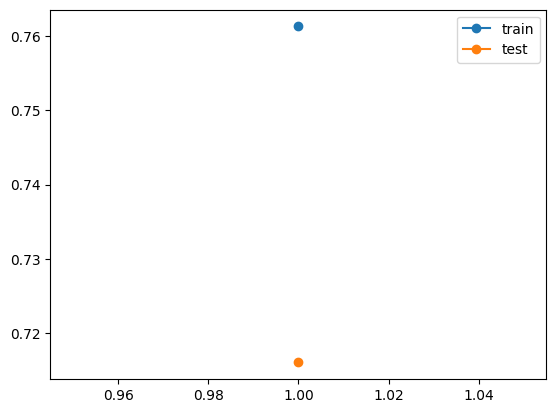

In [199]:
param_values = [int(x) for x in np.linspace(195,205,10)] # max_bin = 198
param_values = [int(x) for x in np.linspace(90,110,20)] # num_iterations = 99
param_values = [float(x) for x in np.linspace(0.13,0.15,50)] # learning_rate = 0.14714
param_values = [int(x) for x in np.linspace(20,40,20)] # num_leaves = 31
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = LGBMClassifier()
  model.set_params(max_bin=198,learning_rate=0.14714,num_iterations=99,num_leaves=31)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

Based on Learning Curve, we get these best parameters:
- max_bin = 198
- num_iterations = 99
- learning_rate = 0.14714
- num_leaves = 31

In [200]:
# check using learning curve parameters
lclgbm = LGBMClassifier()
lclgbm.set_params(max_bin=198,learning_rate=0.14714,num_iterations=99,num_leaves=31)
lclgbm.__name__ = 'LGBMClassifier_LearningCurve'
lclgbm.fit(X_train, y_train)
explain_model(lclgbm)

LGBMClassifier_LearningCurve Evaluation

PR AUC (test): 0.7160
PR AUC (train): 0.7613
Diff PR AUC: 0.0453

Recall (test): 0.7638
Recall (train): 0.8035
Diff Recall: 0.0397

Precision (test): 0.8608
Precision (train): 0.8842
Diff Precision: 0.0233

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [201]:
# hyperparameter
max_bin = [int(x) for x in np.linspace(195,205,10)] # max_bin = 198
num_iterations = [int(x) for x in np.linspace(90,110,20)] # num_iterations = 99
learning_rate = [float(x) for x in np.linspace(0.13,0.15,50)] # learning_rate = 0.14714
num_leaves = [int(x) for x in np.linspace(20,40,20)] # num_leaves = 31
hyperparameters = dict(max_bin=max_bin, num_iterations=num_iterations, learning_rate=learning_rate, num_leaves=num_leaves)

# Randomized Search CV
model = LGBMClassifier()
rslgbm = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_iter=100)
rslgbm.fit(X_train, y_train)
explain_model(rslgbm)

LGBMClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.7041
PR AUC (train): 0.7622
Diff PR AUC: 0.0581

Recall (test): 0.7508
Recall (train): 0.8027
Diff Recall: 0.0519

Precision (test): 0.8556
Precision (train): 0.8858
Diff Precision: 0.0302

----------------------------------------------------------------------------------------------------


In [202]:
# check best parameters
rslgbm.best_params_

{'num_leaves': 33,
 'num_iterations': 101,
 'max_bin': 205,
 'learning_rate': 0.14061224489795918}

### XGBClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7515471; test pr auc: 0.7001668; diff: 0.0513803


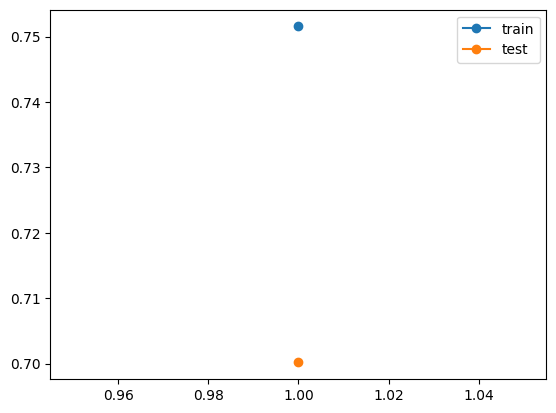

In [203]:
param_values = [int(x) for x in np.linspace(3,8)] # min_child_weight = 3 or 8
param_values = [float(x) for x in np.linspace(0.97,0.98,20)] # subsample = 0.9747368421052631
param_values = [float(x) for x in np.linspace(0,1,20)] # gamma = 0.6842105263157894
param_values = [float(x) for x in np.linspace(0.35,0.4,20)] # eta = 0.37894736842105264
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = XGBClassifier()
  model.set_params(min_child_weight=3,subsample=0.9747368421052631,gamma=0.6842105263157894,eta=0.37894736842105264)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

Based on Learning Curve, we get these best parameters:
- min_child_weight = 3
- subsample = 0.9747368421052631
- gamma = 0.6842105263157894
- eta = 0.37894736842105264

In [204]:
# check using learning curve parameters
lcxgb = XGBClassifier()
lcxgb.set_params(min_child_weight=3,subsample=0.9747368421052631,gamma=0.6842105263157894,eta=0.37894736842105264)
lcxgb.__name__ = 'XGBlcassifier_LearningCurve'
lcxgb.fit(X_train, y_train)
explain_model(lcxgb)

XGBlcassifier_LearningCurve Evaluation

PR AUC (test): 0.7002
PR AUC (train): 0.7515
Diff PR AUC: 0.0514

Recall (test): 0.7367
Recall (train): 0.7856
Diff Recall: 0.0489

Precision (test): 0.8619
Precision (train): 0.8859
Diff Precision: 0.0240

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [205]:
# hyperparameter
min_child_weight = [int(x) for x in np.linspace(3,8)] # min_child_weight = 3 or 8
subsample = [float(x) for x in np.linspace(0.97,0.98,20)] # subsample = 0.9747368421052631
gamma = [float(x) for x in np.linspace(0,1,20)] # gamma = 0.6842105263157894
eta = [float(x) for x in np.linspace(0.35,0.4,20)] # eta = 0.37894736842105264
hyperparameters = dict(min_child_weight=min_child_weight, subsample=subsample, gamma=gamma, eta=eta)

# Randomized Search CV
model = XGBClassifier()
rsxgb = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_iter=100)
rsxgb.fit(X_train, y_train)
explain_model(rsxgb)

XGBClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.6914
PR AUC (train): 0.7732
Diff PR AUC: 0.0818

Recall (test): 0.7335
Recall (train): 0.8022
Diff Recall: 0.0687

Precision (test): 0.8526
Precision (train): 0.8999
Diff Precision: 0.0473

----------------------------------------------------------------------------------------------------


In [206]:
# check best parameters
rsxgb.best_params_

{'subsample': 0.9789473684210526,
 'min_child_weight': 3,
 'gamma': 0.42105263157894735,
 'eta': 0.3657894736842105}

### CatBoostClassifier

#### Learning Curve

param value: 1; train pr auc: 0.7859463; test pr auc: 0.7178913; diff: 0.0680550


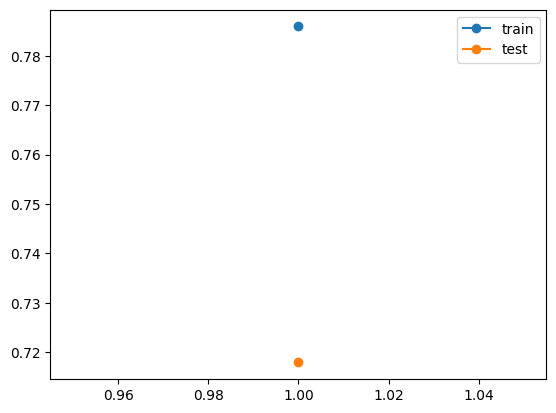

In [207]:
param_values = [float(x) for x in np.linspace(0.01,0.06,10)] # learning_rate = 0.03222222222222222
param_values = [int(x) for x in np.linspace(1,10,10)] # depth = 6
param_values = [float(x) for x in np.linspace(0.1,0.2,10)] # l2_leaf_reg = 0.15555555555555556
param_values = [1]

train_scores = []
test_scores = []

for p in param_values:
  model = CatBoostClassifier(verbose=False)
  model.set_params(learning_rate=0.03222222222222222, depth=6, l2_leaf_reg=0.15555555555555556)
  model.fit(X_train, y_train)

  # eval di train data
  y_pred_train = model.predict(X_train)
  train_scores.append(metrics.average_precision_score(y_train, y_pred_train))

  # eval di test data
  y_pred = model.predict(X_test)
  test_scores.append(metrics.average_precision_score(y_test, y_pred))

  print(f"param value: {p}; train pr auc: {train_scores[-1]:.7f}; test pr auc: {test_scores[-1]:.7f}; diff: {train_scores[-1]-test_scores[-1]:.7f}")

plt.plot(param_values, train_scores, label='train', marker='o')
plt.plot(param_values, test_scores, label='test', marker='o')
plt.legend()
plt.show()

In [208]:
# check using learning curve parameters
lccat = CatBoostClassifier(verbose=False)
lccat.set_params(learning_rate=0.03222222222222222, depth=6, l2_leaf_reg=0.15555555555555556)
lccat.__name__ = 'CatBoostlcassifier_LearningCurve'
lccat.fit(X_train, y_train)
explain_model(lccat)

CatBoostlcassifier_LearningCurve Evaluation

PR AUC (test): 0.7179
PR AUC (train): 0.7859
Diff PR AUC: 0.0681

Recall (test): 0.7497
Recall (train): 0.8160
Diff Recall: 0.0662

Precision (test): 0.8748
Precision (train): 0.9047
Diff Precision: 0.0299

----------------------------------------------------------------------------------------------------


#### Randomized Search CV

In [209]:
# hyperparameter
learning_rate = [float(x) for x in np.linspace(0.01,0.06,10)] # learning_rate = 0.03222222222222222
depth = [int(x) for x in np.linspace(1,10,10)] # depth = 6
l2_leaf_reg = [float(x) for x in np.linspace(0.1,0.2,10)] # l2_leaf_reg = 0.15555555555555556
hyperparameters = dict(learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg)

# Randomized Search CV
model = CatBoostClassifier(verbose=False)
rscat = RandomizedSearchCV(model, hyperparameters, scoring='average_precision', cv=StratifiedKFold(n_splits=5), random_state=1, n_jobs=3)
rscat.fit(X_train, y_train)
explain_model(rscat)

CatBoostClassifier_RandomizedSearchCV Evaluation

PR AUC (test): 0.7052
PR AUC (train): 0.8309
Diff PR AUC: 0.1257

Recall (test): 0.7302
Recall (train): 0.8509
Diff Recall: 0.1207

Precision (test): 0.8742
Precision (train): 0.9311
Diff Precision: 0.0569

----------------------------------------------------------------------------------------------------


In [210]:
# check best parameters
rscat.best_params_

{'learning_rate': 0.03777777777777778,
 'l2_leaf_reg': 0.14444444444444446,
 'depth': 7}

## K. Ensemble Methods

### Stacking Classifier

In [211]:
# define level-1 algorithm
level1 = list()
level1.append(('lgbm', lclgbm))
level1.append(('cat', lccat))
level1.append(('xgb', lcxgb))

# define level-2 algorithm
level2 = lclgbm

# fit model
sc = StackingClassifier(estimators=level1, final_estimator=level2, cv=StratifiedKFold(n_splits=5))
sc.fit(X_train, y_train)
explain_model(sc)


StackingClassifier Evaluation

PR AUC (test): 0.7096
PR AUC (train): 0.7735
Diff PR AUC: 0.0639

Recall (test): 0.7638
Recall (train): 0.8144
Diff Recall: 0.0506

Precision (test): 0.8525
Precision (train): 0.8907
Diff Precision: 0.0382

----------------------------------------------------------------------------------------------------


### Voting Classifier

In [212]:
vc = VotingClassifier(estimators=level1, voting='soft')
vc.fit(X_train, y_train)
explain_model(vc)

VotingClassifier Evaluation

PR AUC (test): 0.7194
PR AUC (train): 0.7710
Diff PR AUC: 0.0517

Recall (test): 0.7562
Recall (train): 0.8063
Diff Recall: 0.0500

Precision (test): 0.8714
Precision (train): 0.8940
Diff Precision: 0.0226

----------------------------------------------------------------------------------------------------


## L. Pickle

In [213]:
# pickle ordinalencoder, minmaxscaler, and lclgbm model
joblib.dump(oe, 'fastapi/pickle/ordinalencoder.pkl')
joblib.dump(scaler, 'fastapi/pickle/minmaxscaler.pkl')
joblib.dump(lclgbm, 'fastapi/pickle/lclgbm.pkl')

['fastapi/pickle/lclgbm.pkl']

## Summary

In [214]:
models = [lr,knn,dt,rf,ada,xgb,lgb,cat,lclgbm,lccat,lcxgb,rslgbm,rsxgb,rscat,sc,vc]

eval_model(models,fit=False)

,name,pr_auc_test,pr_auc_train,recall_test,recall_train,precision_test,precision_train,diff_pr_auc,diff_recall,diff_precision
8,LGBMClassifier_LearningCurve,0.716003,0.761335,0.763814,0.803467,0.860806,0.884151,0.045332,0.039653,0.023346
14,StackingClassifier,0.709643,0.773531,0.763814,0.814428,0.852479,0.890716,0.063888,0.050614,0.038238
15,VotingClassifier,0.719373,0.771034,0.756230,0.806271,0.871411,0.894008,0.051661,0.050041,0.022597
6,LGBMClassifier,0.704099,0.739906,0.755146,0.786643,0.852078,0.870276,0.035808,0.031497,0.018198
11,LGBMClassifier_RandomizedSearchCV,0.704090,0.762176,0.750813,0.802702,0.855556,0.885795,0.058085,0.051889,0.030239
9,CatBoostlcassifier_LearningCurve,0.717891,0.785946,0.749729,0.815957,0.874842,0.904748,0.068055,0.066228,0.029906
5,XGBClassifier,0.692227,0.794638,0.737811,0.819781,0.850187,0.912340,0.102411,0.081969,0.062153
7,CatBoostClassifier,0.702575,0.764561,0.737811,0.796839,0.864213,0.893398,0.061986,0.059028,0.029185
10,XGBlcassifier_LearningCurve,0.700167,0.751547,0.736728,0.785623,0.861850,0.885887,0.051380,0.048895,0.024036
12,XGBClassifier_RandomizedSearchCV,0.691419,0.773183,0.733478,0.802192,0.852645,0.899914,0.081764,0.068714,0.047269


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

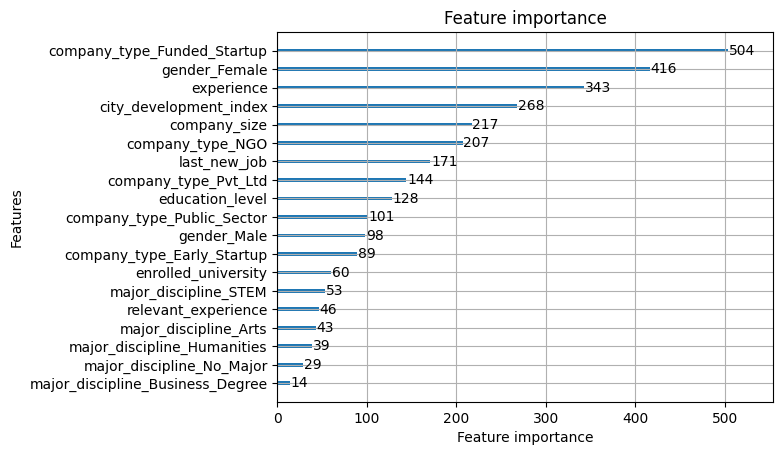

In [215]:
plot_importance(lclgbm)

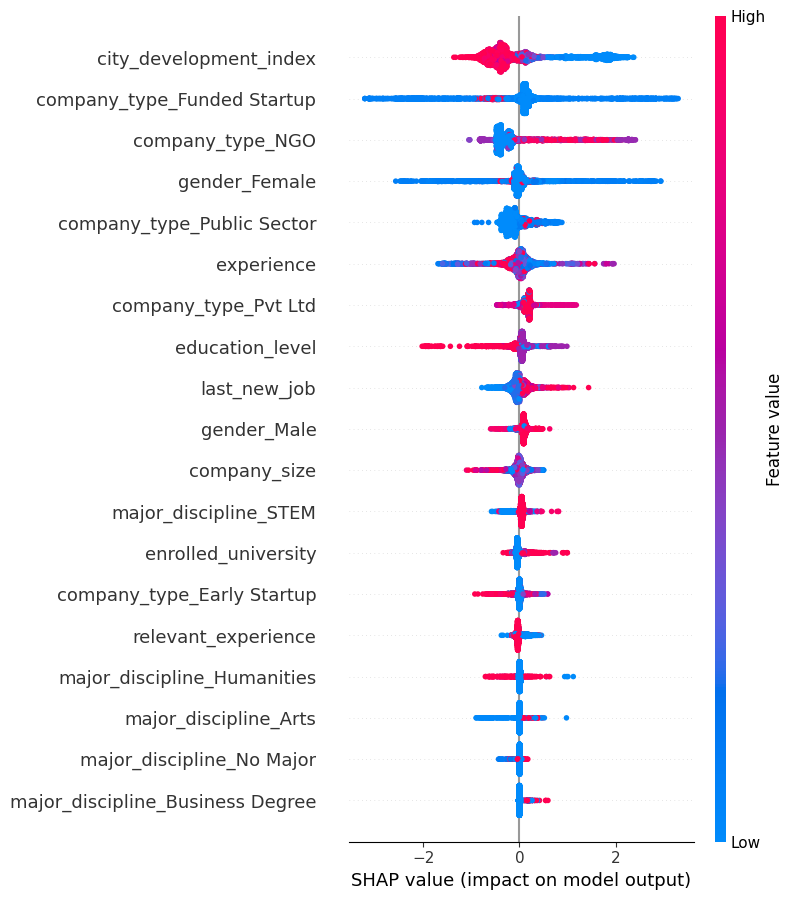

In [216]:
# shap
explainer = shap.TreeExplainer(lclgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())

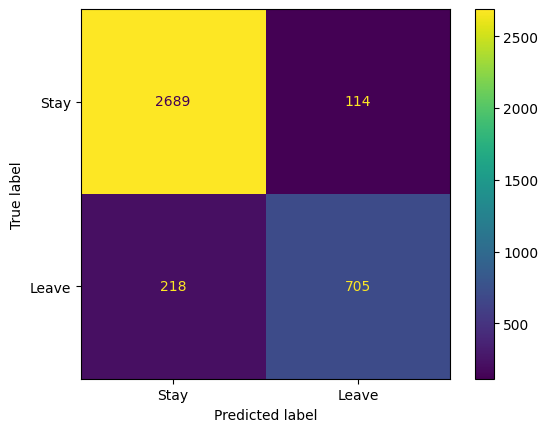

In [217]:
# display confusion matrix
cm = metrics.confusion_matrix(y_test, lclgbm.predict(X_test), labels=[0.0,1.0])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stay","Leave"])
disp.plot()
plt.show()

# Summary

1. After considering 35+ [combinations](https://docs.google.com/spreadsheets/d/1fHVYzMt236zO0H9nlIeZy1kKM4ujnzb5wPbysHgyq3Q/edit?gid=625641172#gid=625641172) for preprocessing dataset, we conclude that the best preprocessing dataset is:
> Drop 'city' and 'training_hours', drop rows with equal or more than 4 NaN values, ordinal encoding + ohe, MICE imputation using LinearRegression, split test_size=0.2, SMOTE with sampling_strategy=0.35, MinMaxScaler
2. We use MICE imputation using LinearRegression because it can drastically increase the accuracy of our model. Based on PR-AUC, it increased from ~40% to amazing >70%. We analyze that although this dataset is classification, this dataset is not from the real world, so using LinearRegression may break the code for creating this dataset.
3. We consider take best model based on 3 factors: first, it needs to be above 70% in PR-AUC Test. We using PR-AUC since our dataset is imbalanced (25:75). Second, it needs to have the highest Recall Test. Third, it needs to not overfitting or underfitting.
4. The best model that we will take is LGBMClassifier with Learning Curve to determine the best parameter. It resulted with 71.6% in PR-AUC Test, 76.38% in Recall Test, and 86.08% in Precision Test.
5. We can see features that impact greatly the target are: City Development Index (CDI), Company Type (Funded Startup or NGO), Gender (Female), and Experience.
6. Based on SHAP Values; higher CDI, higher Experience, higher Education Level (PhD or Master), or higher Company Size mean lower chance of leaving the company. However; currently enroll in university or do not have data science experience tends to the leave company.
7. Based on SHAP Values, higher Last New Job means higher chance to leave the company. It is different with our previous analysis when EDA. We analyze that this is because SHAP can get the hidden correlation between Last New Job to target. This hidden correlation can't be described using simple linear regression in EDA.
8. We pickle 3 objects for our FastAPI as backend in our final project. These objects are ML model, Min Max Scaler, and Label Encoding.

# Business Recomendation

1. We suggest Ascencio to search client or company with lower City Development Index (<0.7 CDI), have lower Company Size (100 employees or more), or NGO Company. This strategy targets company with employee tend to leave, creating higher consulting value through retention solutions.
2. For choosing participants in data science courses, the company should choose employee that have higher experience working (11 years or above), have higher education level (Phd or Masters), are newer in their current company (1 years or lower), do not currently enrolling in university, and/or relevant experience in data science.
3. Because we target employees that have higher experience working, Ascencio need to make curriculum of data science with focus that can easily be learned by people aged 30-40 years old.
4. Employees with STEM major or employees that have relevant experience in data science usually take this data science courses, Ascencio can make curriculum of data science that will more focus on business knowledge than math or programming.
5. If company still want to participate employee who show higher likelihood of leaving, suggest that company to implement specific retention strategies such as special contract, mentorship programs, career development plans, or special incentives.

# Bonus: Guarantee Program

Ascencio can develop a "Retention Guarantee Program" for a period of time and offering partial refunds if client attrition exceeds 15% within 1 year of implementation, creating confidence in our services. This program only apply if company wants to analysis minimum certain employees. 

By using test data that have 3726 rows data with 25:75 proportion of ‘leaving employee’ in target, we can generate several samples. This sample can have several rows that represent number of employee. With this sample data, we can predict using our machine learning model and get confusion matrix. This confusion matrix can generate attrition rate. This is the result for differents number of minimum employees to analysis:

In [218]:
# make new dataframe for testing guarantee program
df_gr = X_test.copy()
df_gr = df_gr.join(y_test.reset_index(drop=True))

In [219]:
# function to create random sample data for testing guarantee program
def random_guarantee(sample_data_number, employees_number, treshold=15):
    att_rate = []
    for i in range(sample_data_number):
        # Calculate start and end indices for the current segment
        start_idx = i * employees_number
        end_idx = (i + 1) * employees_number
        
        # Extract features and target for the current segment
        X_test_gr = df_gr[start_idx:end_idx].drop('target', axis=1)
        y_test_gr = df_gr[start_idx:end_idx]['target']
        
        # Generate predictions and confusion matrix
        y_pred_gr = lclgbm.predict(X_test_gr)
        confusion_mat = metrics.confusion_matrix(y_test_gr, y_pred_gr, labels=[0.0,1.0])
        
        # Calculate and display the attrition rate
        attrition_rate = confusion_mat[1,0] / (confusion_mat[0,0] + confusion_mat[1,0]) * 100

        # Store value
        att_rate.append(attrition_rate)
        loss = [num for num in att_rate if num >= treshold]
    return att_rate, loss


In [220]:
print("With totally random data for Guarantee Program")
print("-"*100)
# 125 sample data for 30 employees
sample_data_number = 125
employees_number = 30
att_rate, loss = random_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

# 107 sample data for 35 employees
sample_data_number = 107
employees_number = 35
att_rate, loss = random_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

# 93 sample data for 40 employees
sample_data_number = 93
employees_number = 40
att_rate, loss = random_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

With totally random data for Guarantee Program
----------------------------------------------------------------------------------------------------
For 125 sample data with 30 employees,
Only 11 data have attrition more than 15% or 8.80% failed

For 107 sample data with 35 employees,
Only 6 data have attrition more than 15% or 5.61% failed

For 93 sample data with 40 employees,
Only 6 data have attrition more than 15% or 6.45% failed



In [221]:
# function to create stratify random sample data for testing guarantee program
def stratify_guarantee(sample_data_number, employees_number, treshold=15):
    att_rate = []
    # Create a stratified k-fold splitter
    skf = StratifiedKFold(n_splits=sample_data_number, shuffle=True, random_state=42)

    # Get your features and target
    X = df_gr.drop('target', axis=1)
    y = df_gr['target']

    # Iterate through the stratified folds
    for i, (_, test_indices) in enumerate(skf.split(X, y)):
        # Limit to employees_number if needed
        if len(test_indices) > employees_number:
            # Maintain stratification when downsizing
            class_indices = {}
            for idx in test_indices:
                label = y.iloc[idx]
                if label not in class_indices:
                    class_indices[label] = []
                class_indices[label].append(idx)
            
            # Calculate how many samples to take from each class
            class_0_count = int(employees_number * 0.75)  # 75% staying
            class_1_count = employees_number - class_0_count  # 25% leaving
            
            # Randomly select indices while maintaining proportion
            selected_indices = np.random.choice(class_indices[0.0], class_0_count, replace=False).tolist()
            selected_indices += np.random.choice(class_indices[1.0], class_1_count, replace=False).tolist()
            test_indices = np.array(selected_indices)
        
        # Extract the current stratified segment
        X_test_gr = X.iloc[test_indices]
        y_test_gr = y.iloc[test_indices]
        
        # Generate predictions and confusion matrix
        y_pred_gr = lclgbm.predict(X_test_gr)
        confusion_mat = metrics.confusion_matrix(y_test_gr, y_pred_gr, labels=[0.0, 1.0])
        
        # Calculate attrition rate
        attrition_rate = confusion_mat[1,0] / (confusion_mat[0,0] + confusion_mat[1,0]) * 100 if (confusion_mat[0,0] + confusion_mat[1,0]) > 0 else 0
        
        # Store value in att_rate
        att_rate.append(attrition_rate)
        loss = [num for num in att_rate if num >= treshold]
    return att_rate, loss

In [222]:
print("With stratify random data for Guarantee Program")
print("-"*100)
# 125 sample data for 30 employees
sample_data_number = 125
employees_number = 30
att_rate, loss = stratify_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

# 107 sample data for 35 employees
sample_data_number = 107
employees_number = 35
att_rate, loss = stratify_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

# 93 sample data for 40 employees
sample_data_number = 93
employees_number = 40
att_rate, loss = stratify_guarantee(sample_data_number,employees_number)
print(f"For {sample_data_number} sample data with {employees_number} employees,")
print(f"Only {len(loss)} data have attrition more than 15% or {len(loss)/sample_data_number*100:.2f}% failed")
print("")

With stratify random data for Guarantee Program
----------------------------------------------------------------------------------------------------
For 125 sample data with 30 employees,
Only 15 data have attrition more than 15% or 12.00% failed

For 107 sample data with 35 employees,
Only 7 data have attrition more than 15% or 6.54% failed

For 93 sample data with 40 employees,
Only 5 data have attrition more than 15% or 5.38% failed



Ascencio can determine their calculated risk for this Guarantee Program to gain more profit. 
Just remember that maximum of minimum employees is only 100 & don’t take calculated risk more than 10%.